In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain-openai langchainhub langchain-community

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

open_ai_key = os.environ['OPENAI_API_KEY']=os.getenv("OPENAI_API_KEY")

In [2]:
## Loading model and embedder
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

model = ChatOpenAI(model="gpt-4o", temperature=0)
embedder = OpenAIEmbeddings()

In [3]:
from langchain_community.document_loaders import PyPDFLoader

# load document from arxiv
loader = PyPDFLoader("example_data/meeting_data.pdf")
paper = loader.load()

In [4]:
%pip install -U faiss-cpu

   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/14.6 MB 2.8 MB/s eta 0:00:06
   --- ------------------------------------ 1.3/14.6 MB 3.4 MB/s eta 0:00:04
   ----- ---------------------------------- 1.8/14.6 MB 3.4 MB/s eta 0:00:04
   ------- -------------------------------- 2.6/14.6 MB 3.2 MB/s eta 0:00:04
   ------- -------------------------------- 2.9/14.6 MB 3.0 MB/s eta 0:00:04
   ---------- ----------------------------- 3.7/14.6 MB 3.0 MB/s eta 0:00:04
   ----------- ---------------------------- 4.2/14.6 MB 3.0 MB/s eta 0:00:04
   ------------- -------------------------- 5.0/14.6 MB 3.1 MB/s eta 0:00:04
   --------------- ------------------------ 5.8/14.6 MB 3.1 MB/s eta 0:00:03
   ----------------- ---------------------- 6.6/14.6 MB 3.1 MB/s eta 0:00:03
   ------------------- -------------------- 7.1/14.6 MB 3.1 MB/s eta 0:00:03
   --------------------- ------------------ 7.9/14.6 MB 3.2 MB/s eta 0:00:03
   ---

In [5]:
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
)

# text splits for the document
chunks_paper = text_splitter.split_documents(paper)

# storing in vector store
faiss_db_paper = FAISS.from_documents(chunks_paper, embedder)


In [6]:
## creating retriever

retriever_paper = faiss_db_paper.as_retriever()

In [7]:
## converting the retriever to a Tool

from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(retriever_paper, "RAG doc", "Search for info on RAG")

In [11]:
# test it!

retriever_tool.invoke("Cuando fue la reunion?")

'Reunión de planificación - 15 de agosto de 2024\nAsistentes:\n- Juan Pérez\n- María González\n- Luis Fernández\n- Ana Martínez\nAgenda:\n1. Revisión de los objetivos del trimestre pasado.\n2. Planificación de las próximas actividades.\n3. Asignación de responsabilidades.\n4. Preguntas y respuestas.\nConclusiones:\n- Se logró el 85% de los objetivos del trimestre pasado.\n- Se identificaron áreas de mejora en la comunicación interna.\n- Las actividades prioritarias para el próximo trimestre incluyen la mejora de procesos y la\ncapacitación del personal.\nLa próxima reunión está programada para el 20 de septiembre de 2024.'

In [ ]:
! pip install arxiv

In [15]:
! pip install wikipedia

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11705 sha256=da2f6dc4cc6d1f34e850cb7bcb6e651f0de7104dcc2b13731752e74f304060e0
  Stored in directory: c:\users\diana\appdata\local\pip\cache\wheels\63\47\7c\a9688349aa74d228ce0a9023229c6c0ac52ca2a40fe87679b8
Successfully built wikipedia


In [14]:
## Load multiple tools

from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools.wikipedia.tool import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

# arxiv tool
arxiv =  ArxivAPIWrapper()

# wikipedia tool
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

ImportError: Could not import wikipedia python package. Please install it with `pip install wikipedia`.

In [11]:
## api key for tools

# serpapi
os.environ['SERPAPI_API_KEY']=getpass.getpass()
# tavily
os.environ['TAVILY_API_KEY']=getpass.getpass()

In [12]:
## Langchain api key
LANGCHAIN_TRACING_V2="true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY']=getpass.getpass()

In [ ]:
%pip install -U langchain-community tavily-python

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import SerpAPIWrapper

# tavily tool
tavily = TavilySearchResults(max_results=1)

# serpapi tool
serpapi = SerpAPIWrapper()

In [14]:
from langchain.tools import Tool

## A proper name and a good description helps to know on how to use the tools, otherwise ToolExecutor will not work
wiki_tool = Tool.from_function(
    func=wikipedia.run,
    name="wiki",
    description="useful for when you need to search certain topic on Wikipedia, aka wiki")

arxiv_tool = Tool.from_function(
    func=arxiv.run,
    name="arxiv",
    description="useful for querying from arxiv repository")

tavily_tool = Tool.from_function(
    func= tavily.invoke,
    name = 'tavily',
    description = 'Search Engine'
)

serpapi_tool = Tool.from_function(
    func= serpapi.run,
    name = 'serpapi',
    description = 'Search Engine'
)



# List of all tools
tools = [wiki_tool, arxiv_tool, tavily_tool, serpapi_tool, retriever_tool] 

In [15]:
%pip install -q httpx
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation # reinstall langgraph if fails!

# This a helper class we have that is useful for running tools
# It takes in an agent action and calls that tool and returns the result
tool_executor = ToolExecutor(tools)

Note: you may need to restart the kernel to use updated packages.


In [47]:
# test it
invocation = ToolInvocation(tool="RAG doc", tool_input="What is Retrieval Augmented Generation?")

tool_executor.invoke(invocation)

'Abstract—Large Language Models (LLMs) showcase impres- sive capabilities but encounter challenges like hallucination, outdated knowledge, and non-transparent, untraceable reasoning processes. Retrieval-Augmented Generation (RAG) has emerged as a promising solution by incorporating knowledge from external databases. This enhances the accuracy and credibility of the generation, particularly for knowledge-intensive tasks, and allows for continuous knowledge updates and integration of domain- specific information. RAG synergistically merges LLMs’ intrin- sic knowledge with the vast, dynamic repositories of external databases. This comprehensive review paper offers a detailed examination of the progression of RAG paradigms, encompassing the Naive RAG, the Advanced RAG, and the Modular RAG. It meticulously scrutinizes the tripartite foundation of RAG frameworks, which includes the retrieval, the generation and the augmentation techniques. The paper highlights the state-of-the- art\n\nIndex 

In [16]:
## PROMPT TEMPLATE

from langchain.memory import ConversationBufferMemory
from langchain_core.prompts import PromptTemplate

## set up memory
memory = ConversationBufferMemory(memory_key="chat_history", input_key='input', output_key="output")

prompt_template = """
### [INST]

Assistant is a large language model to answer questions on Retrieval Augmented Generation.


Context:
------

Assistant has access to the following tools:

{tools}

To use a tool, please use the following format:

'''
Thought: Do I need to use a tool? Yes
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
'''

When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:

'''
Thought: Do I need to use a tool? No
Final Answer: [your response here]
'''

Begin!

Previous conversation history:
{chat_history}

New input: {input}

Current Scratchpad:
{agent_scratchpad}

[/INST]
 """

# Create prompt from prompt template
prompt = PromptTemplate(
    input_variables=['agent_scratchpad', 'chat_history', 'input', 'tool_names', 'tools'],
    template=prompt_template,
)

prompt = prompt.partial(
    tools=[t.name for t in tools],
    tool_names=", ".join([t.name for t in tools]),
)
print("prompt ---> \n", prompt)

prompt ---> 
 input_variables=['agent_scratchpad', 'chat_history', 'input'] partial_variables={'tools': ['wiki', 'arxiv', 'tavily', 'serpapi', 'RAG doc'], 'tool_names': 'wiki, arxiv, tavily, serpapi, RAG doc'} template="\n### [INST]\n\nAssistant is a large language model to answer questions on Retrieval Augmented Generation.\n\n\nContext:\n------\n\nAssistant has access to the following tools:\n\n{tools}\n\nTo use a tool, please use the following format:\n\n'''\nThought: Do I need to use a tool? Yes\nAction: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action\nObservation: the result of the action\n'''\n\nWhen you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:\n\n'''\nThought: Do I need to use a tool? No\nFinal Answer: [your response here]\n'''\n\nBegin!\n\nPrevious conversation history:\n{chat_history}\n\nNew input: {input}\n\nCurrent Scratchpad:\n{agent_scratchpad}\n\n[/INST]\n "


In [50]:
## Creating React Agent
from langchain import hub

# Get the prompt to use - you can modify this!
prompt = hub.pull("hwchase17/react")
print(prompt)

input_variables=['agent_scratchpad', 'input', 'tool_names', 'tools'] metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'react', 'lc_hub_commit_hash': 'd15fe3c426f1c4b3f37c9198853e4a86e20c425ca7f4752ec0c9b0e97ca7ea4d'} template='Answer the following questions as best you can. You have access to the following tools:\n\n{tools}\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\nThought: I now know the final answer\nFinal Answer: the final answer to the original input question\n\nBegin!\n\nQuestion: {input}\nThought:{agent_scratchpad}'


In [17]:
from langchain.agents import AgentExecutor, create_react_agent

# Construct the ReAct agent
agent = create_react_agent(model, tools, prompt)

# Create an agent executor by passing in the agent and tools
agent_executor = AgentExecutor(agent=agent, 
                               tools=tools, 
                               verbose=True,
                               handle_parsing_errors=True,
                               max_iterations=3,
                               return_intermediate_steps=True,
                               early_stopping_method="generate")

In [ ]:
# test it !
agent_outcome = agent_executor.invoke({"input": "what is Adaptive RAG?","chat_history": []})
agent_outcome

In [27]:
agent_action = agent_outcome['intermediate_steps'][0][0]
output = tool_executor.invoke(agent_action)
agent_action

AgentAction(tool='serpapi', tool_input='current weather in Montreal"\n\'\'\'', log='\'\'\'\nThought: Do I need to use a tool? Yes\nAction: serpapi\nAction Input: "current weather in Montreal"\n\'\'\'')

In [28]:
# create agent state class

from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    # The input string
    input: str
    # The list of previous messages in the conversation
    chat_history: list[BaseMessage]
    # The outcome of a given call to the agent
    # Needs `None` as a valid type, since this is what this will start as
    agent_outcome: Union[AgentAction, AgentFinish, None]
    # List of actions and corresponding observations
    # Here we annotate this with `operator.add` to indicate that operations to
    # this state should be ADDED to the existing values (not overwrite it)
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [29]:
# Define the nodes
from langchain_core.agents import AgentActionMessageLog

def run_agent(data):
    inputs = data.copy()
    text = inputs['input']
    # chat_history = inputs['chat_history']
    agent_outcome = agent_executor.invoke({"input":text}) #, "chat_history": chat_history
    return {"agent_outcome": agent_outcome}

# Define the function to execute tools
def execute_tools(data):
    # Get the most recent agent_outcome - this is the key added in the `agent` above
    agent_output = data["agent_outcome"]
    if len(agent_output['intermediate_steps'])>=1 :
        agent_action = agent_output['intermediate_steps'][0][0]
        output = tool_executor.invoke(agent_action)
        return {"intermediate_steps": [(agent_action, str(output))]}
    else:
        return {"intermediate_steps":[]}

# Define logic that is used to determine which conditional edge to go down
def should_continue(data):
    # If the agent outcome is an AgentFinish, then we return `exit` string
    # This will be used when setting up the graph to define the flow
    if data["agent_outcome"]["output"] is not None:
        print(" **AgentFinish** " )
        return "end"
    # Otherwise, an AgentAction is returned
    # Here we return `continue` string
    # This will be used when setting up the graph to define the flow
    else:
        print(" **continue** " )
        return "continue"

In [30]:
from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", run_agent)
workflow.add_node("action", execute_tools)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

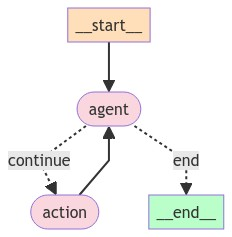

In [33]:
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
inputs = {"input": "Explain Adaptive Retrieval methods"} # ,"chat_history": []
outputs = app.invoke(inputs)

In [ ]:
inputs = {"input": "Explain what are Langchain Agents. Use appropriate metaphor to connect with real-life instances"} # ,"chat_history": []
outputs = app.invoke(inputs)

In [61]:
outputs['agent_outcome']['output']

'Adaptive retrieval methods involve modifying or enhancing retrieval systems to improve their performance in specific contexts or tasks. These methods include:\n\n1. **Parameter-Efficient Adaptation**: Utilizing adapters to add small layers to models, enabling efficient transfer learning and domain adaptation without extensive retraining.\n2. **Adaptation-Guided Retrieval**: Focusing on retrieving cases based on their adaptability rather than just structural similarity, using graphical models like Metric Markov Random Fields.\n3. **Context-Specific Adaptation**: Tailoring models to the specific content of the target collection to improve both recognition and retrieval accuracy, especially in speech-driven text retrieval.\n\nThese methods aim to enhance the relevance, precision, and efficiency of retrieval systems by incorporating adaptability and context-specific adjustments.'